# Replicating the ViT (Vision Transformer) Paper
link = https://arxiv.org/pdf/2010.11929v2.pdf

In [1]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

In [2]:
import torch
from torch import nn

## Getting Data

In [4]:
from get_data import download_data
image_path = download_data('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip', 'pizza_steak_sushi')

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [5]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir

PosixPath('data/pizza_steak_sushi/train')

## Converting data into dataloaders
* Creating a custom made transform to apply
    * Resize the image to 224, 224 [based on the Paper]
    * Convert image pixels to tensors
* Using our own function create_dataloaders to create train and test dataloaders


In [6]:
from torchvision import transforms

IMG_SIZE = 224 # Comes from the ViT paper
BATCH_SIZE = 32 # Paper uses 4096

transform = transforms.Compose([
    transforms.Resize(size= (IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()]
)

print(f"Manual transform: {transform}")

Manual transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
from data_setup import create_dataloaders

train_data_loader, test_data_loader, class_names = create_dataloaders(train_dir, test_dir, transform, BATCH_SIZE)
train_data_loader, test_data_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe883bd74c0>,
 ['pizza', 'steak', 'sushi'])

### Visualise a single image
* Turn the dataloader into a Python iterator
* Take the first image and label of the batch
* Plot the image with the label on top  

In [8]:
import torch
torch.manual_seed(9)
image_batch, label_batch = next(iter(train_data_loader))

image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

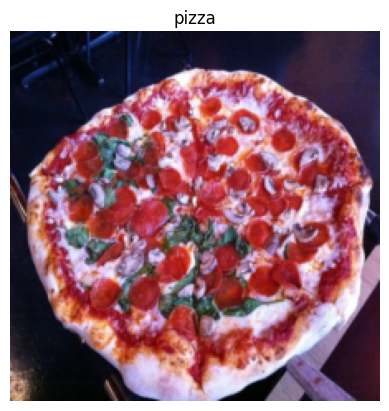

In [9]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Replicating the ViT: Overview
Every DL model can be broken down into a series of small pieces

* **Inputs** : What goes into the model
* **Outputs** : What comes out of the model/layer/block
* **Layers** : Take an input, manipulates it with a function (ex: self attention)
* **Blocks** : Collection of layers
* **Total Model** : Collection of blocks

## Figure 1
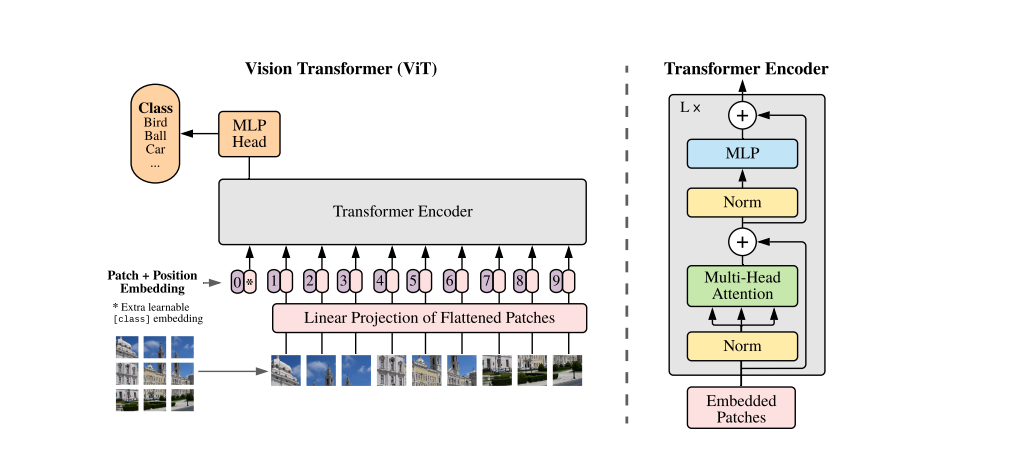

* MLP -> Multilayer Perceptron
* Norm -> Normalisation Layer


### A Vision Transformer consists of the following essential components:

* **Input Embedding**: This is where the image is divided into smaller patches and transformed into embeddings.

* **Positional Encoding**: ViTs don't have built-in spatial information, so positional encoding is added to provide the model with the position of each patch in the image.

* **Multi-Head Self-Attention**: ViTs use multi-head self-attention mechanisms to capture relationships between different patches.

* **Feed-Forward Neural Networks (FFNs)**: After attention mechanisms, the model passes the information through FFNs to make predictions.

* **Layer Normalization**: This ensures stable training and helps in the flow of information.

LayerNorm helps stabilize gradients by scaling and shifting the normalized activations using learnable parameters. This scaling factor ensures that the gradients neither vanish (become too small) nor explode (become too large), thus facilitating faster convergence.

## Four Equations
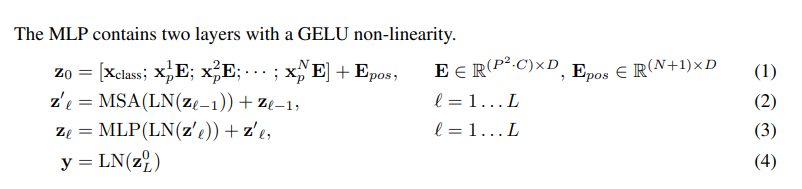
* MSA -> Multi-Head Self Attention

### Equation 1
* The standard Transformer receives as input a 1D sequence of token embeddings.
* Reshape the image into a sequence of flattened 2D patches
* Position embeddings are added to the patch embeddings to retain positional information
* Class_token is used to represent which class does the current input belong to
```
x_input = [class_token, x_patch1, x_patch2, x_patch3 .... x_patchN] + [class_token_position, x_patch1_pos, x_patch2_pos....]
```

### Equation 2
* Takes the output of equation 1 and passes it through MSA Block
```
x_output_MSA_block = MSA_Layer(LN_Layer(x_input)) + x_input
```

### Equation 3
```
x_output_MLP_block = MLP_Layer(LN_Layer(x_output_MSA_block)) + x_output_MSA_block
```

## Equation 1
* Split data into patches
* Creating class, position and patch embeddings
* Input shape -> (224, 224, 3)
* Output shape -> (N * P**2 * C)
* Patch size -> 16 (using ViT-B/16)

In [ ]:
## Calculating the number of patches by hand
height = 224
width = 224
color_channels = 3
patch_size = 16

num_of_patches = (height * width) // patch_size ** 2
print(f"The total number of patches are {num_of_patches}")
print(f"The output shape is {(num_of_patches, patch_size ** 2 * color_channels)}")

The total number of patches are 196
The output shape is (196, 768)


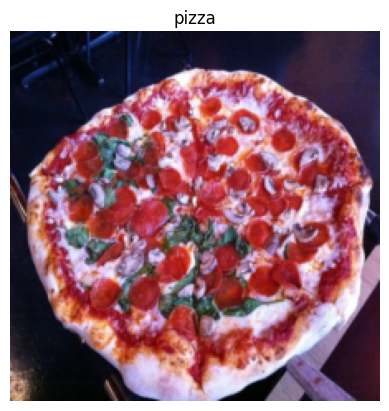

In [ ]:
## Turning images into patches
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

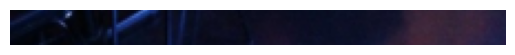

In [ ]:
# Getting the top row of the image
image_permuted = image.permute(1, 2, 0)

plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

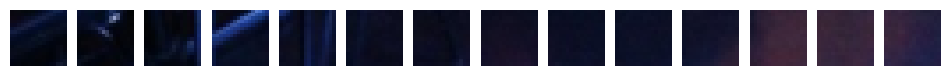

In [ ]:
img_size = 224

fig, ax = plt.subplots(figsize= (12, 8), nrows= 1, ncols= img_size // patch_size,
                       sharex= True, sharey= True)

# Iterate through the number of patches in top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    ax[i].imshow(image_permuted[:patch_size, patch : patch + patch_size, :])
    ax[i].axis(False);

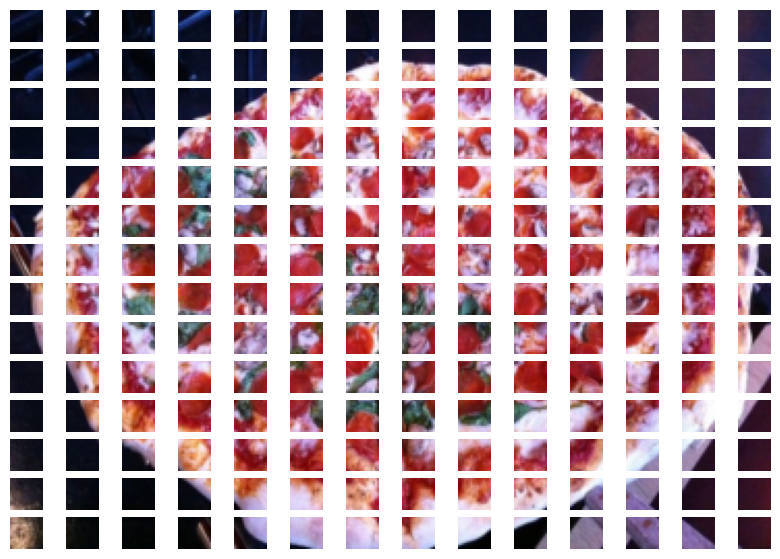

In [ ]:
## Patching the entire image
fig, ax = plt.subplots(figsize= (10, 7), nrows= img_size // patch_size,
                       ncols= img_size // patch_size, sharex= True, sharey= True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    for j, patch_col in enumerate(range(0, img_size, patch_size)):
        ax[i][j].imshow(image_permuted[patch : patch + patch_size, patch_col : patch_col + patch_size, :])
        ax[i][j].axis(False);

In [ ]:
## Creating the patches and turning them into embeddings
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels= 3, out_channels= 768, kernel_size= patch_size,
                   stride= patch_size, padding= 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
## Passing the image through conv2d layer
img_out_of_conv = conv2d(image.unsqueeze(0)) # to add a batch dimension
img_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [ ]:
## Visualize some of the 768 patch embeddings (convolutional feature maps)
import random
random_idx = random.sample(range(0, 768), k= 5)
print(f"We take random samples from indexes: {random_idx}")

We take random samples from indexes: [576, 66, 99, 401, 145]


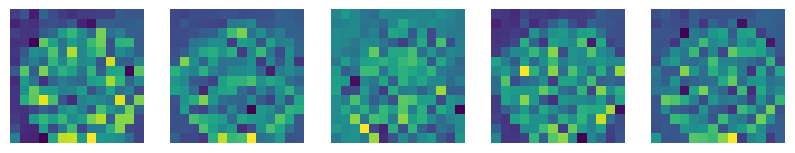

In [ ]:
fig, ax = plt.subplots(figsize= (10, 7), ncols= 5)
for i, idx in enumerate(random_idx):
    feature_map = img_out_of_conv[:, idx, :, :]
    ax[i].imshow(feature_map.squeeze().detach().numpy())
    ax[i].axis(False);

In [ ]:
## Flattening the output of conv2d
flatten_layer = nn.Flatten(start_dim= 2, end_dim= -1)
img_flattened = flatten_layer(img_out_of_conv)
print(img_flattened.shape)

# To order the shape in line with our model's input shape
img_flattened = img_flattened.permute(0, 2, 1)
img_flattened.shape # 196 patches of 768 numbers (learnable) each

torch.Size([1, 768, 196])


torch.Size([1, 196, 768])

In [ ]:
## Visualising the flattened vector
rand_idx = random.sample(range(0, 196), k= 5)
print(f"Random indexes: {rand_idx}")

fig, ax = plt.subplots(figsize= (10, 7), ncols= 5)

for i, idx in enumerate(rand_idx):
    random_vector = img_flattened[:, idx, :]
    ax[i].imshow(random_vector.detach().numpy())
    ax[i].axis(False);

Random indexes: [132, 171, 48, 90, 177]


### Turning the patch embedding layer into a PyTorch module

In [ ]:
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(self, input_shape, output_shape, patch_size):
        super().__init__()
        self.patch_size = patch_size
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape, out_channels= output_shape,
                      kernel_size= patch_size, stride= patch_size, padding= 0),
            nn.Flatten(start_dim= 2, end_dim= -1)
        )

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        return self.block_1(x).permute(0, 2, 1)

In [ ]:
torch.manual_seed(17)
patchify = PatchEmbedding(3, 768, 16)
print(f"Image shape: {image.unsqueeze(0).shape}")
image_patched = patchify(image.unsqueeze(0))
print(f"Output shape: {image_patched.shape}")

Image shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768])


### Create a class token


In [ ]:
## Creating a batch size and embedding dim
batch_size = image_patched.shape[0]
embedding_dim = image_patched.shape[-1]
batch_size, embedding_dim

(1, 768)

In [ ]:
# Creating the class token embedding as a learnable parameter
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim), requires_grad= True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Adding class token to the front of the patch embedding
patch_embedded_image_with_class_token = torch.cat((class_token, image_patched), dim= 1)
patch_embedded_image_with_class_token.shape

torch.Size([1, 197, 768])

### Creating a position embedding

In [ ]:
position_embedding = nn.Parameter(torch.randn(batch_size, (num_of_patches + 1), embedding_dim))
position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
patch_and_position_embedding = patch_embedded_image_with_class_token + position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

### Equation 1 : Putting it all together

In [ ]:
# Setting patch size
patch_size = 16

# Adding batch to image
print(f"Original image shape: {image.shape}")
image_batch = image.unsqueeze(0)
batch_size = image_batch.shape[0]
print(f"Image with batch dimension added: {image_batch.shape}")

# Patching the image
image_patched = patchify(image_batch)
embedding_dim = image_patched.shape[-1]
print(f"Image patchified: {image_patched.shape}")

# Adding class token
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim), requires_grad= True)
image_patched_with_class_token = torch.cat((class_token, image_patched), dim= 1)
print(f"Patched image after adding class token: {image_patched_with_class_token.shape}")

# Adding position embedding
position_embedding = nn.Parameter(torch.randn(batch_size, num_of_patches + 1, embedding_dim))
patch_and_position_embedding = image_patched_with_class_token + position_embedding
print(f"Output of equation 1: {patch_and_position_embedding.shape}")

Original image shape: torch.Size([3, 224, 224])
Image with batch dimension added: torch.Size([1, 3, 224, 224])
Image patchified: torch.Size([1, 196, 768])
Patched image after adding class token: torch.Size([1, 197, 768])
Output of equation 1: torch.Size([1, 197, 768])


## Equation 2 (MSA Block)
### Attention
* The attention mechanism allows the model to focus on different parts of an image while considering the relationships between those parts.
* It captures long term dependencies in images
* Think of it as a way for the model to decide which parts of the image to focus on when analyzing it.
* Like a mental spotlight that can be directed to different areas of an image.

### Layer Norm (Layer Normalisation )
* Technique to normalise the distributions of intermediate layers
* Enables smoother gradients, faster compute and better generalisation accuracy
* Normalisation: Make everything have the same mean and standard deviation

In [ ]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, input_shape, num_heads):
        super().__init__()
        self.norm_layer = nn.LayerNorm(normalized_shape= input_shape)

        self.MultiheadAttentionLayer = nn.MultiheadAttention(embed_dim= input_shape,
                                                             num_heads= num_heads,
                                                             batch_first= True)

    def forward(self, x):
        x = self.norm_layer(x)
        attention_output, _ = self.MultiheadAttentionLayer(query= x, key= x, value= x, need_weights= False)

        return attention_output

In [ ]:
msa_block_1 = MultiheadSelfAttention(input_shape= embedding_dim, num_heads= 12)
msa_block_1

MultiheadSelfAttention(
  (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (MultiheadAttentionLayer): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
)

In [ ]:
image_out_of_msa_block = msa_block_1(patch_and_position_embedding)
image_out_of_msa_block.shape

torch.Size([1, 197, 768])

In [ ]:
patch_and_position_embedding

tensor([[[ 0.2895,  0.7114, -0.4867,  ..., -1.0273, -1.4202, -2.1263],
         [-0.1357,  0.4380,  0.1000,  ...,  0.7517,  1.9968,  0.6162],
         [ 0.7744, -1.4232,  1.7524,  ...,  0.8903,  1.3942,  0.5400],
         ...,
         [-0.3367,  0.6097,  0.5842,  ..., -0.2966, -0.3702, -1.3590],
         [ 1.5301,  0.3963, -1.7310,  ...,  0.1397,  0.5604, -0.8920],
         [ 0.3504,  1.0479,  0.1060,  ...,  0.4568,  0.8847,  1.1137]]],
       grad_fn=<AddBackward0>)

In [ ]:
image_out_of_msa_block

tensor([[[ 3.9021e-02,  8.1173e-02,  1.2567e-01,  ...,  2.2260e-02,
          -2.4054e-01, -1.4349e-01],
         [ 1.5054e-04,  9.0582e-02,  1.1136e-01,  ...,  6.3431e-03,
          -2.0995e-01, -1.2016e-01],
         [ 5.2234e-02,  1.0163e-01,  1.1947e-01,  ...,  2.2413e-03,
          -1.9353e-01, -1.2968e-01],
         ...,
         [ 1.5173e-02,  1.1452e-01,  1.1631e-01,  ..., -1.3049e-02,
          -1.8905e-01, -1.4371e-01],
         [ 2.1118e-02,  8.1450e-02,  1.4825e-01,  ..., -2.5750e-02,
          -2.0585e-01, -1.2141e-01],
         [ 4.3618e-02,  9.0753e-02,  1.3635e-01,  ...,  2.8046e-02,
          -2.2404e-01, -1.4978e-01]]], grad_fn=<TransposeBackward0>)

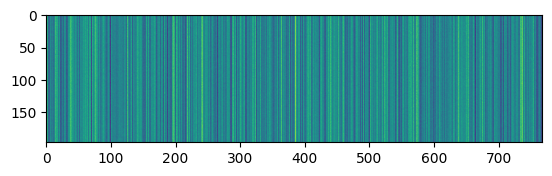

In [ ]:
plt.imshow(image_out_of_msa_block.squeeze().detach().numpy());

## Equation 3 (MLP Block)
* MLP block consists of 2 layers with GeLU non linearity
* Hidden units = 3072 for ViT Base (from table 1)
* GeLU -> Gaussian error Linear Unit
* Dropout = 0.1 (Table 3)


In [ ]:
class MLP_Block(nn.Module):
    def __init__(self, input_shape, hidden_units : int= 3072, dropout: int= 0.1):
        super().__init__()

        self.MLP_layer = nn.Sequential(
            nn.LayerNorm(normalized_shape= input_shape),
            nn.Linear(in_features= input_shape, out_features= hidden_units),
            nn.GELU(),
            nn.Dropout(p= dropout),
            nn.Linear(in_features= hidden_units, out_features= input_shape),
            nn.GELU(),
            nn.Dropout(p= dropout)
        )

    def forward(self, x):
        return self.MLP_layer(x)


In [ ]:
mlp_block = MLP_Block(input_shape= embedding_dim)
mlp_block

MLP_Block(
  (MLP_layer): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=3072, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=3072, out_features=768, bias=True)
    (5): GELU(approximate='none')
    (6): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
image_out_of_mlp_block = mlp_block(image_out_of_msa_block)
image_out_of_mlp_block.shape

torch.Size([1, 197, 768])

In [ ]:
image_out_of_mlp_block

tensor([[[ 0.0549, -0.0248,  0.0877,  ...,  0.1437,  0.1475,  0.0503],
         [-0.0350,  0.0131, -0.0185,  ..., -0.0073,  0.0526,  0.0893],
         [-0.0171, -0.0828,  0.0088,  ...,  0.1792,  0.1324,  0.0000],
         ...,
         [ 0.0140, -0.0710,  0.1222,  ...,  0.1297,  0.0845,  0.0488],
         [ 0.0000, -0.0031,  0.0252,  ...,  0.1337,  0.2053,  0.1278],
         [ 0.0232, -0.0424, -0.0409,  ...,  0.0893,  0.1008,  0.0802]]],
       grad_fn=<MulBackward0>)

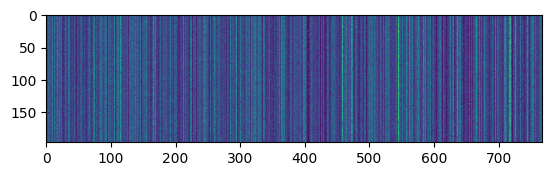

In [ ]:
plt.imshow(image_out_of_mlp_block.squeeze().detach().numpy());

## Creating Transformer encoder
* Encoder -> Turn a sequence into learnable representation

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_shape: int, num_heads: int, hidden_units: int= 3072, dropout: int= 0.1):
        super().__init__()
        # Creating the MSA block (equation 2)
        self.MSA_block = MultiheadSelfAttention(input_shape, num_heads)

        # Creating the MLP block (equation 3)
        self.MLP_block = MLP_Block(input_shape, hidden_units, dropout)

    def forward(self, x):
        y = self.MSA_block(x) + x # Residual connection (ResNet is made from it)
        return self.MLP_block(y) + y

In [ ]:
transformer_encoder_block = TransformerEncoder(768, 12)

summary(transformer_encoder_block, (1, 197, 768),
        col_names= ["input_size", "output_size", "num_params", "trainable",],
        col_width= 20, row_settings= ["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)                 [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttention (MSA_block)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (MultiheadAttentionLayer)     --                   [1, 197, 768]        2,362,368            True
├─MLP_Block (MLP_block)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Sequential (MLP_layer)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─LayerNorm (0)                               [1, 197, 768]        [1, 197, 768]        1,536                True
│  

## Create a Transformer Encoder layer with in built PyTorch layer

In [ ]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model= embedding_dim,
                                                             nhead= 12,
                                                             dim_feedforward= 3072,
                                                             dropout= 0.1,
                                                             activation= "gelu",
                                                             batch_first= True,
                                                             norm_first= True)

In [ ]:
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(torch_transformer_encoder_layer, (1, 197, 768),
        col_names= ["input_size", "output_size", "num_params", "trainable",],
        col_width= 20, row_settings= ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Putting it all together

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size: int= 224, in_channels: int= 3,
                 patch_size: int= 16, num_transformer_layers: int= 12,
                 embedding_dim: int= 768, num_heads: int= 12,
                 MLP_hidden_units: int= 3072, dropout: int= 0.1,
                 num_classes: int= 3):
        super().__init__()

        # assertion to check if img_size is compatible with patch size
        assert img_size % patch_size == 0 , f"Image size {img_size} must be divisible by Patch size {patch_size}"

        # Calculating the number of patches
        self.num_patches = (img_size ** 2) // patch_size ** 2

        # Create learnable class embedding
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad= True)

        # Creating the position embedding
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, embedding_dim, requires_grad= True))

        # Create patch embedding layer
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels= in_channels, out_channels= embedding_dim,
                      kernel_size= patch_size, stride= patch_size),
            nn.Flatten(start_dim= 2, end_dim= -1))

        # Create the Transformer Encoder block
        self.transformer_block = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, MLP_hidden_units,
                                       dropout, "gelu", batch_first= True, norm_first= True),
            num_layers= num_transformer_layers)

        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape= embedding_dim),
            nn.Linear(in_features= embedding_dim, out_features= num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) #expand the token to every image in a batch

        patched_img = self.patch_embed(x).permute(0, 2, 1)
        img_with_class_token = torch.cat((class_token, patched_img), dim= 1)
        position_embeded_img_with_class_token = img_with_class_token + self.position_embedding

        # Passing the image through the layers of transformer encoder
        transformer_output = self.transformer_block(position_embeded_img_with_class_token)

        # Passing the 0th index (class token) through the classifier head
        return self.classifier(transformer_output[:, 0])

In [ ]:
model_0 = ViT()
model_0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ViT(
  (patch_embed): Sequential(
    (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (1): Flatten(start_dim=2, end_dim=-1)
  )
  (transformer_block): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=3

In [ ]:
summary(model_0, (1, 3, 224, 224), col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width= 20, row_settings= ["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                     [1, 3, 224, 224]     [1, 3]               152,064              True
├─Sequential (patch_embed)                    [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    └─Conv2d (0)                             [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (1)                            [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─TransformerEncoder (transformer_block)      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                    --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─TransformerEncoderLayer (1)       [1, 197, 768]        [1, 197, 768]     

## Setting up training code for ViT

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
torch.manual_seed(17)
model_0 = ViT()
model_0.to(device)

ViT(
  (patch_embed): Sequential(
    (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (1): Flatten(start_dim=2, end_dim=-1)
  )
  (transformer_block): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=3

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params= model_0.parameters(), lr= 0.001, weight_decay= 0.1) #weight_decay -> L2 Regularisation

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

accuracy_fn = Accuracy(task= 'multiclass', num_classes= len(class_names)).to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from engine import train
epochs = 5

results = train(model_0, train_data_loader, test_data_loader, loss_fn ,optimizer, device, epochs, accuracy_fn)

  0%|          | 0/5 [00:00<?, ?it/s]



****** For Epoch: 1 ******
Train_loss: 2.3498315811157227 | Train_acc: 0.375
Test_loss: 2.539307117462158 | Test_acc: 0.1979166716337204



****** For Epoch: 2 ******
Train_loss: 1.612056016921997 | Train_acc: 0.31640625
Test_loss: 1.4519070386886597 | Test_acc: 0.1979166716337204



****** For Epoch: 3 ******
Train_loss: 1.9229258298873901 | Train_acc: 0.26171875
Test_loss: 1.1391735076904297 | Test_acc: 0.2604166865348816



****** For Epoch: 4 ******
Train_loss: 1.311110019683838 | Train_acc: 0.27734375
Test_loss: 1.5651925802230835 | Test_acc: 0.1979166716337204



****** For Epoch: 5 ******
Train_loss: 1.422022819519043 | Train_acc: 0.2890625
Test_loss: 1.7301366329193115 | Test_acc: 0.2604166865348816



In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size: int= 224, patch_size: int= 16,
                 embedding_dim: int= 768, in_channels: int= 3,
                 num_heads: int= 12, num_of_transformer_layers: int= 12):
        super().__init__()

        assert img_size % patch_size == 0, f"image size: {img_size} is not divisible by patch size: {patch_size}"

        self.num_of_patches = (img_size ** 2) // patch_size ** 2

        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad= True)

        self.position_embedding = nn.Parameter(torch.randn(1, (self.num_of_patches+1), embedding_dim))

        self.patch_embedding_layer = nn.Sequential(
            nn.Conv2d(in_channels= in_channels, out_channels= embedding_dim, kernel_size= patch_size, stride= patch_size),
            nn.Flatten(start_dim= 2, end_dim= -1)
        )

        self.transformer_block = nn.TransformerEncoder(
            nn.TransformerEncoderLayer()
        )

## What is our model missing
* Data -> Original transformer trained on millions of images (vs our 225)
* Gradient clipping, Learning rate deacy, Learning rate warmup

## PLotting the loss curves

In [ ]:
results

{'train_loss': [array(2.3498316, dtype=float32),
  array(1.612056, dtype=float32),
  array(1.9229258, dtype=float32),
  array(1.31111, dtype=float32),
  array(1.4220228, dtype=float32)],
 'test_loss': [array(2.539307, dtype=float32),
  array(1.451907, dtype=float32),
  array(1.1391735, dtype=float32),
  array(1.5651926, dtype=float32),
  array(1.7301366, dtype=float32)]}

In [ ]:
%%writefile loss_curve_plotter.py
import matplotlib.pyplot as plt
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "test_loss": [...],
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]


    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

Writing loss_curve_plotter.py


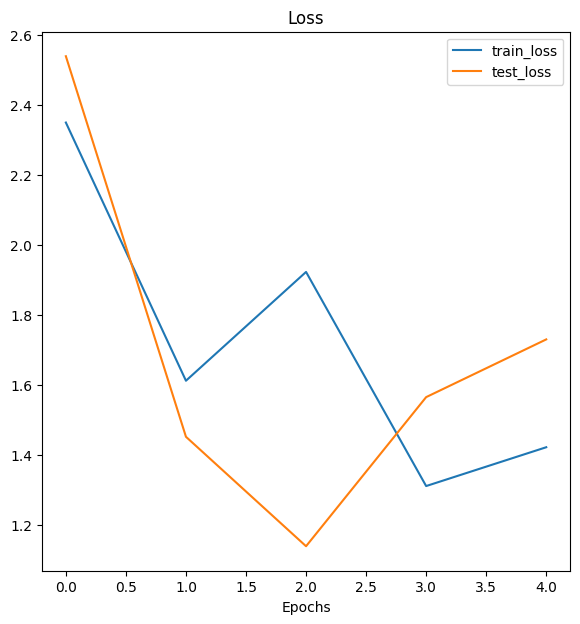

In [ ]:
plot_loss_curves(results)

## Using Transfer Learning

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from torchvision import models
weights = models.ViT_B_16_Weights.DEFAULT
pretrained_vit = models.vit_b_16(weights= weights).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 114MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Freezing all parameters

In [ ]:
for params in pretrained_vit.parameters():
    params.requires_grad = False

In [ ]:
from torchinfo import summary

summary(model= pretrained_vit, input_size= (1, 3, 224, 224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width= 20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d: 1-1                                 [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder: 1-2                                [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout: 2-1                           [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential: 2-2                        [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]        [1, 197, 768

### Change the classifier head

In [ ]:
pretrained_vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
pretrained_vit.heads = nn.Linear(in_features= 768, out_features= len(class_names),
                                 bias= True).to(device)

In [ ]:
summary(model= pretrained_vit, input_size= (1, 3, 224, 224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width= 20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d: 1-1                                 [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder: 1-2                                [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout: 2-1                           [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential: 2-2                        [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]        [1, 197, 7

### Setting data to input in our pretrained ViT model

In [ ]:
vit_transforms = weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir, test_dir, vit_transforms, 32)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

accuracy_fn = Accuracy(task= 'multiclass', num_classes= len(class_names)).to(device)

### Training the feature extractor

In [ ]:
LR = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= pretrained_vit.parameters(), lr= LR)

In [ ]:
from engine import train
EPOCHS = 10

pretrinaed_results = train(pretrained_vit, train_dataloader_pretrained,
                test_dataloader_pretrained, loss_fn, optimizer, device, EPOCHS,
                           accuracy_fn)

  0%|          | 0/10 [00:00<?, ?it/s]



****** For Epoch: 1 ******
Train_loss: 0.711005449295044 | Train_acc: 0.78125
Test_loss: 0.436670184135437 | Test_acc: 0.9280303716659546



****** For Epoch: 2 ******
Train_loss: 0.32389622926712036 | Train_acc: 0.94921875
Test_loss: 0.27912530303001404 | Test_acc: 0.9280303716659546



****** For Epoch: 3 ******
Train_loss: 0.27987992763519287 | Train_acc: 0.95703125
Test_loss: 0.22698122262954712 | Test_acc: 0.917613685131073



****** For Epoch: 4 ******
Train_loss: 0.17212139070034027 | Train_acc: 0.9609375
Test_loss: 0.23968003690242767 | Test_acc: 0.9185606241226196



****** For Epoch: 5 ******
Train_loss: 0.16753052175045013 | Train_acc: 0.96875
Test_loss: 0.24537691473960876 | Test_acc: 0.9185606241226196



****** For Epoch: 6 ******
Train_loss: 0.11828837543725967 | Train_acc: 0.97265625
Test_loss: 0.21421585977077484 | Test_acc: 0.8977272510528564



****** For Epoch: 7 ******
Train_loss: 0.11004257202148438 | Train_acc: 0.97265625
Test_loss: 0.20013245940208435 | Test_a

### Plotting the loss curves

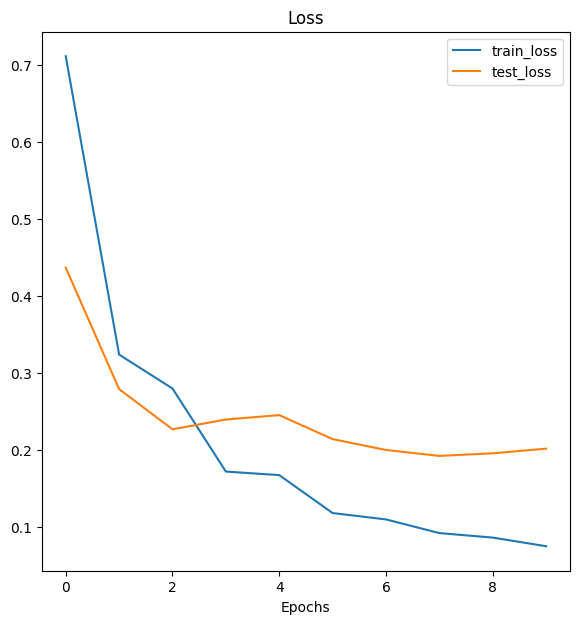

In [ ]:
from loss_curve_plotter import plot_loss_curves
plot_loss_curves(pretrinaed_results)

### Saving our model
need to check size of model in order to deploy

In [ ]:
from utils import save_model
save_model(pretrained_vit, "Fine tuned ViT")

In [ ]:
from pathlib import Path
# checking the model size
pretrained_vit_model_size = Path("Fine tuned ViT.pt").stat().st_size // (1024*1024)
print(f"The model size is {pretrained_vit_model_size} MB")

The model size is 327 MB


### Prediction on custom image

In [ ]:
import os
import matplotlib.pyplot as plt
def custom_image_predictor(model: torch.nn.Module, transform_function, class_names, device= device):
    '''Returns a plot with the image and its predicted class'''
    from google.colab import files
    from PIL import Image
    import shutil

    # Upload the image file
    uploaded = files.upload()

    # Get the first uploaded image
    image_path = list(uploaded.keys())[0]

    # Define the destination folder path
    destination_folder = '/content/data/'

    try:
    # Check if the image file already exists in the destination folder
        if os.path.exists(destination_folder + image_path):
            # Remove the existing image file
            os.remove(destination_folder + image_path)

        # Move the uploaded image to the destination folder
        shutil.move(image_path, destination_folder)

        # Get the new image path in the destination folder
        new_image_path = destination_folder + image_path

        # Open and display the uploaded image from the destination folder
        image = Image.open(new_image_path)

        print("Image uploaded successfully!")

    except Exception as e:
        print("Error occurred while uploading the image:", e)


    # Turn image into tensors
    from torchvision.io import read_image
    image = read_image(new_image_path).type(torch.float) / 255

    # Transformation function
    image_transformed = transform_function(image)

    # Making predictions
    model.to(device)
    model.eval()
    with torch.inference_mode():
        y_logits = model(image_transformed.unsqueeze(dim= 0).to(device))
        y_pred = y_logits.argmax(dim= 1)
        y_pred_prob = torch.softmax(y_logits, dim= 1)

    # Plotting the results
    plt.imshow(image_transformed.permute(1, 2, 0))
    plt.title(f"Pred Class: {class_names[y_pred.cpu()]} | Pred prob: {y_pred_prob.max():.3f}")
    plt.axis(False)

Saving classic-cheese-pizza-recipe-2-64429a0cb408b.jpg to classic-cheese-pizza-recipe-2-64429a0cb408b (1).jpg
Image uploaded successfully!


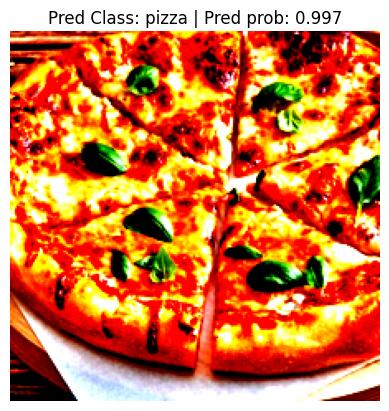

In [ ]:
custom_image_predictor(pretrained_vit, vit_transforms, class_names)